# Bayesian Neural Networks vs Standard DNNs: MNIST Classification Demo

This notebook demonstrates the key differences between standard Deep Neural Networks (DNNs) and Bayesian Neural Networks (BNNs) for classification tasks, particularly focusing on uncertainty quantification.

In [1]:
# Import required libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional

from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# TensorFlow Probability layers
tfd = tfp.distributions
tfpl = tfp.layers

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version: {tfp.__version__}")

TensorFlow version: 2.20.0
TensorFlow Probability version: 0.25.0


## 1. Download and Visualize MNIST Dataset

Training data shape: (60000, 784)
Test data shape: (10000, 784)
Number of classes: 10


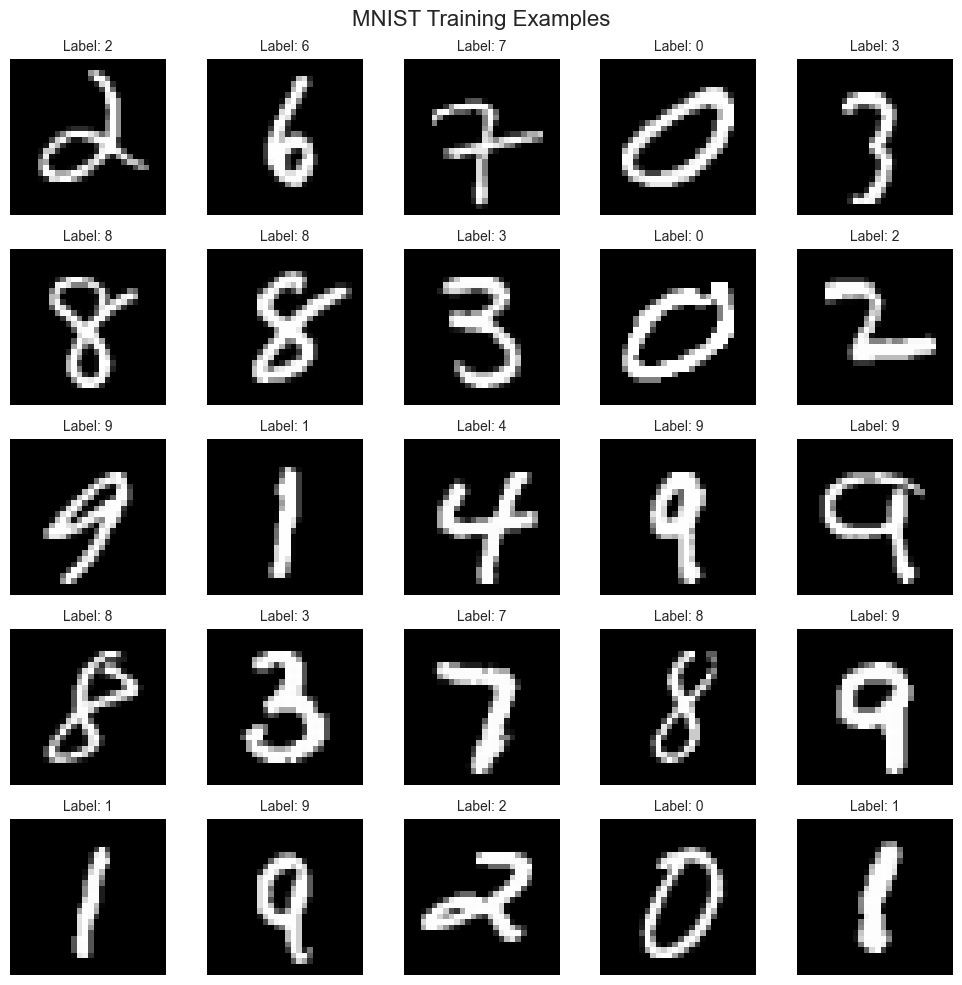

In [3]:
def load_and_preprocess_mnist(normalize: bool = True) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
    """
    Download and preprocess the MNIST dataset.
    
    Args:
        normalize: Whether to normalize pixel values to [0, 1]
    
    Returns:
        Tuple of (train_data, test_data), where each is a tuple of (images, labels)
    """
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Convert to float32 and normalize if requested
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    if normalize:
        x_train /= 255.0
        x_test /= 255.0
    
    # Reshape for neural network input (flatten images)
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    
    return (x_train_flat, y_train), (x_test_flat, y_test)

def visualize_mnist_examples(x_data: np.ndarray, y_data: np.ndarray, 
                            num_examples: int = 25, 
                            title: str = "MNIST Examples",
                            figsize: Tuple[int, int] = (10, 10)):
    """
    Visualize examples from the MNIST dataset.
    
    Args:
        x_data: Image data (can be flattened or 2D)
        y_data: Labels
        num_examples: Number of examples to display
        title: Figure title
        figsize: Figure size
    """
    # Reshape if flattened
    if len(x_data.shape) == 2:
        x_data = x_data.reshape(-1, 28, 28)
    
    # Calculate grid dimensions
    grid_size = int(np.sqrt(num_examples))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    
    # Randomly select examples
    indices = np.random.choice(len(x_data), num_examples, replace=False)
    
    for i, ax in enumerate(axes.flat):
        if i < num_examples:
            idx = indices[i]
            ax.imshow(x_data[idx], cmap='gray')
            ax.set_title(f'Label: {y_data[idx]}', fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load and visualize data
(x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

visualize_mnist_examples(x_train, y_train, num_examples=25, title="MNIST Training Examples")

## 2. Filter Data for Digits 0-4

In [4]:
def filter_digits(x_data: np.ndarray, y_data: np.ndarray, 
                 digit_range: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Filter dataset to include only specified digit range.
    
    Args:
        x_data: Image data
        y_data: Labels
        digit_range: Tuple of (min_digit, max_digit) inclusive
    
    Returns:
        Filtered (x_data, y_data)
    """
    mask = (y_data >= digit_range[0]) & (y_data <= digit_range[1])
    return x_data[mask], y_data[mask]

# Prepare training data (digits 0-4)
x_train_0to4, y_train_0to4 = filter_digits(x_train, y_train, (0, 4))
x_test_0to4, y_test_0to4 = filter_digits(x_test, y_test, (0, 4))

# Prepare OOD test data (digits 5-9)
x_test_5to9, y_test_5to9 = filter_digits(x_test, y_test, (5, 9))

print(f"Training set (0-4): {x_train_0to4.shape[0]} samples")
print(f"Test set (0-4): {x_test_0to4.shape[0]} samples")
print(f"OOD Test set (5-9): {x_test_5to9.shape[0]} samples")

Training set (0-4): 30596 samples
Test set (0-4): 5139 samples
OOD Test set (5-9): 4861 samples


## 3. Train Standard DNN Classifier

Training Standard DNN on digits 0-4...
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9390 - loss: 0.2095 - val_accuracy: 0.9813 - val_loss: 0.0580
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9775 - loss: 0.0751 - val_accuracy: 0.9883 - val_loss: 0.0404
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9838 - loss: 0.0544 - val_accuracy: 0.9901 - val_loss: 0.0318
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0391 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0311 - val_accuracy: 0.9938 - val_loss: 0.0229
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9924 - loss: 0.0253 - val_accuracy: 0.9916 - val_loss: 0.0229
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0220 - val_accuracy: 0.9924 - val_loss: 0.0261
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

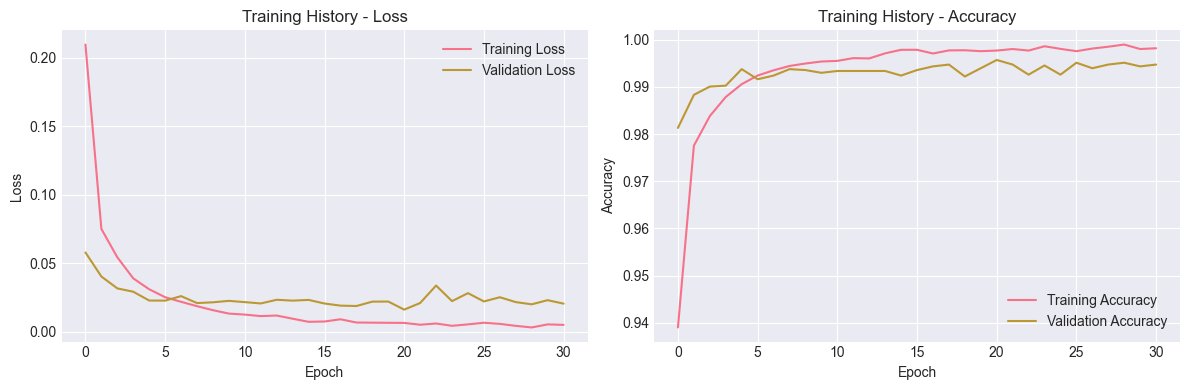


Test accuracy on digits 0-4: 0.9957
Model architecture saved to: outputs/dnn_model.png


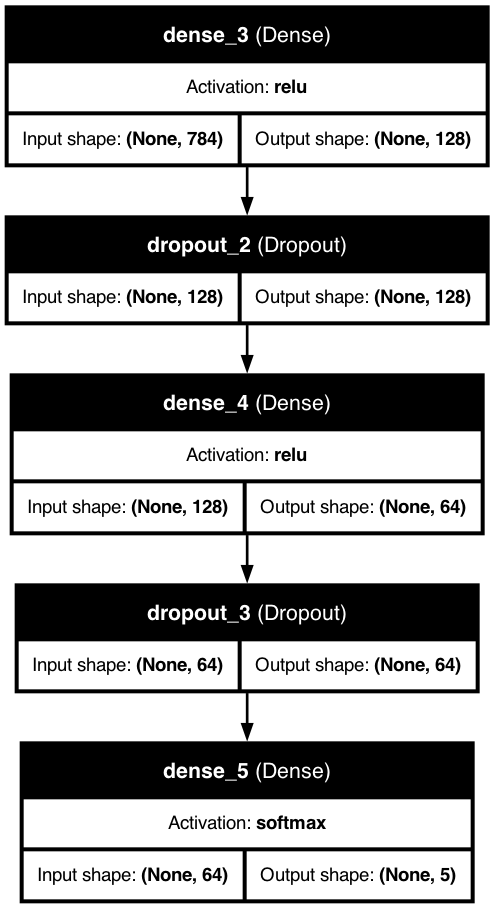

In [6]:
def create_standard_dnn(input_dim: int = 784, 
                       num_classes: int = 5,
                       hidden_units: list = [128, 64]) -> tf.keras.Model:
    """
    Create a standard Deep Neural Network classifier.
    
    Args:
        input_dim: Input dimension (784 for MNIST)
        num_classes: Number of output classes
        hidden_units: List of hidden layer sizes
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(hidden_units[0], activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(hidden_units[1], activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def visualize_model_architecture(model: tf.keras.Model, 
                                 filename: str = 'model_architecture.png',
                                 show_shapes: bool = True,
                                 show_layer_names: bool = True,
                                 show_layer_activations: bool = True,
                                 rankdir: str = 'TB') -> None:
    """
    Create a graphical visualization of the model architecture.
    
    Args:
        model: Trained or compiled Keras model
        filename: Output file name (supports .png, .pdf)
        show_shapes: Whether to display shape information
        show_layer_names: Whether to display layer names
        show_layer_activations: Whether to display activation functions
        rankdir: Direction of graph layout ('TB' for top-to-bottom, 'LR' for left-to-right)
    """
    try:
        tf.keras.utils.plot_model(
            model,
            to_file=filename,
            show_shapes=show_shapes,
            show_layer_names=show_layer_names,
            show_layer_activations=show_layer_activations,
            rankdir=rankdir,
            dpi=96
        )
        print(f"Model architecture saved to: {filename}")
        
        # Display in notebook if using Jupyter
        try:
            display(Image(filename))
        except ImportError:
            print("(Install IPython to display image inline)")
            
    except Exception as e:
        print(f"Error creating visualization: {e}")
        print("\nNote: This requires graphviz and pydot to be installed.")
        print("Install with: pip install pydot graphviz")
        print("Or use visualize_model_summary() for a text-based alternative.")


def train_dnn_classifier(x_train: np.ndarray, y_train: np.ndarray,
                        x_val: np.ndarray, y_val: np.ndarray,
                        epochs: int = 50,
                        batch_size: int = 128,
                        verbose: int = 1) -> tf.keras.Model:
    """
    Train a standard DNN classifier on digits 0-4.
    
    Args:
        x_train, y_train: Training data
        x_val, y_val: Validation data
        epochs: Number of training epochs
        batch_size: Batch size for training
        verbose: Verbosity level
    
    Returns:
        Trained model
    """
    # Create model
    model = create_standard_dnn(input_dim=x_train.shape[1], num_classes=5)
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=verbose
    )
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training History - Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training History - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train the standard DNN
print("Training Standard DNN on digits 0-4...")
dnn_model = train_dnn_classifier(
    x_train_0to4, y_train_0to4,
    x_test_0to4, y_test_0to4,
    epochs=50,
    batch_size=128
)

# Evaluate on test set
test_loss, test_acc = dnn_model.evaluate(x_test_0to4, y_test_0to4, verbose=0)
print(f"\nTest accuracy on digits 0-4: {test_acc:.4f}")

# Visualizing the model architecture
visualize_model_architecture(dnn_model, filename='outputs/dnn_model.png', rankdir='TB')

## 4. Test DNN and Visualize Uncertainty

Probability Estimates on Clean In-Distribution Data:


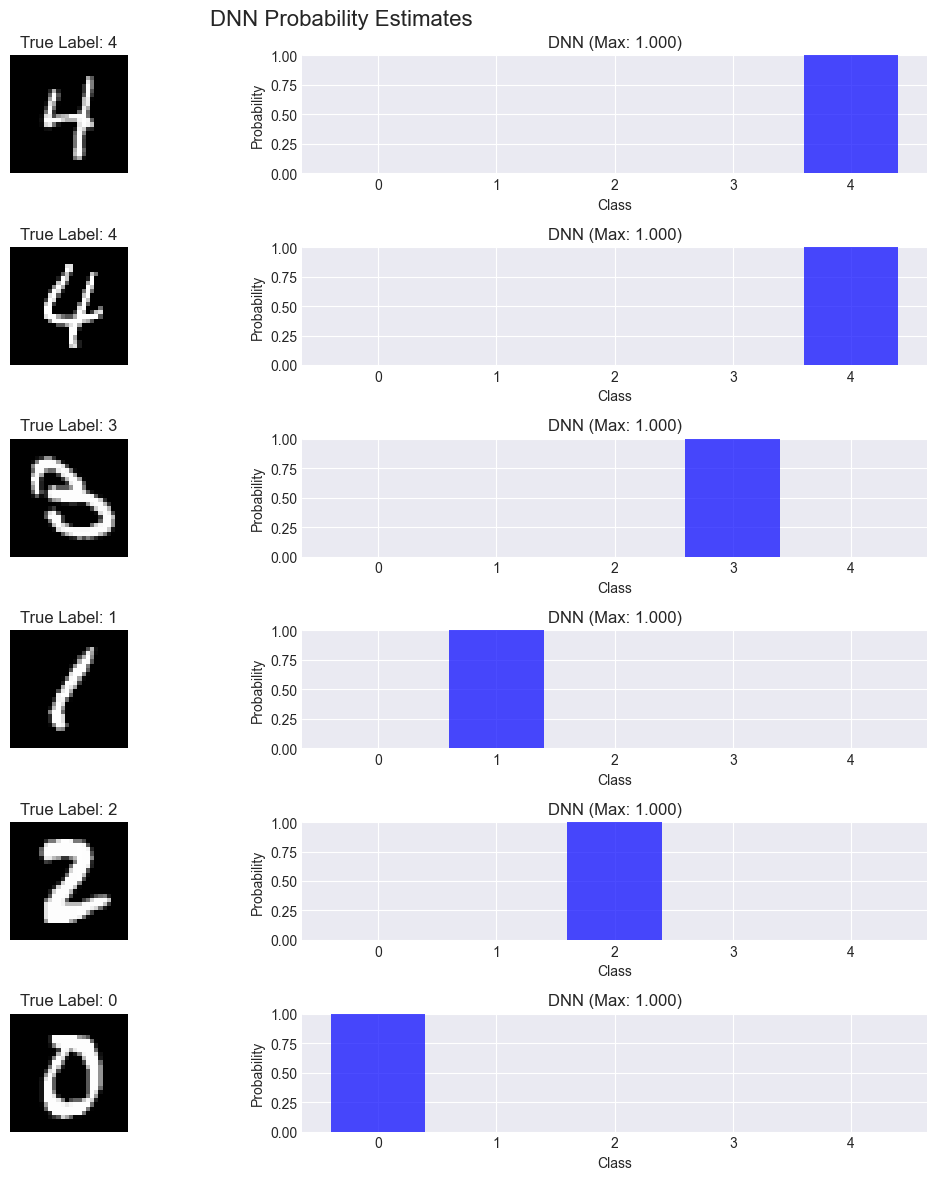

In [7]:
def plot_probabilities_dnn(dnn_model, x_samples, y_samples):
    """
    Examine probability estimates for DNN on specific examples.
    
    Args:
        dnn_model: Standard DNN model
        x_samples: Sample images
        y_samples: True labels
    """
    n_examples = min(6, len(x_samples))
    indices = np.random.choice(len(x_samples), n_examples, replace=False)
    
    fig, axes = plt.subplots(n_examples, 2, figsize=(12, 2*n_examples))
    fig.suptitle('DNN Probability Estimates', fontsize=16)
    
    for i, idx in enumerate(indices):
        x_sample = x_samples[idx:idx+1]
        y_true = y_samples[idx]
        
        # Get DNN predictions
        dnn_probs = dnn_model.predict(x_sample, verbose=0)[0]
                
        # Plot image
        axes[i, 0].imshow(x_sample.reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f'True Label: {y_true}')
        axes[i, 0].axis('off')
        
        # Plot DNN probabilities
        axes[i, 1].bar(range(5), dnn_probs, color='blue', alpha=0.7)
        axes[i, 1].set_ylim([0, 1])
        axes[i, 1].set_xlabel('Class')
        axes[i, 1].set_ylabel('Probability')
        axes[i, 1].set_title(f'DNN (Max: {np.max(dnn_probs):.3f})')
        axes[i, 1].set_xticks(range(5))
            
    plt.tight_layout()
    plt.show()

# Compare on clean in-distribution examples
print("Probability Estimates on Clean In-Distribution Data:")
plot_probabilities_dnn(dnn_model, x_test_0to4[:100], y_test_0to4[:100])

Probability Estimates for cases the model gets wrong for Clean In-Distribution Data:


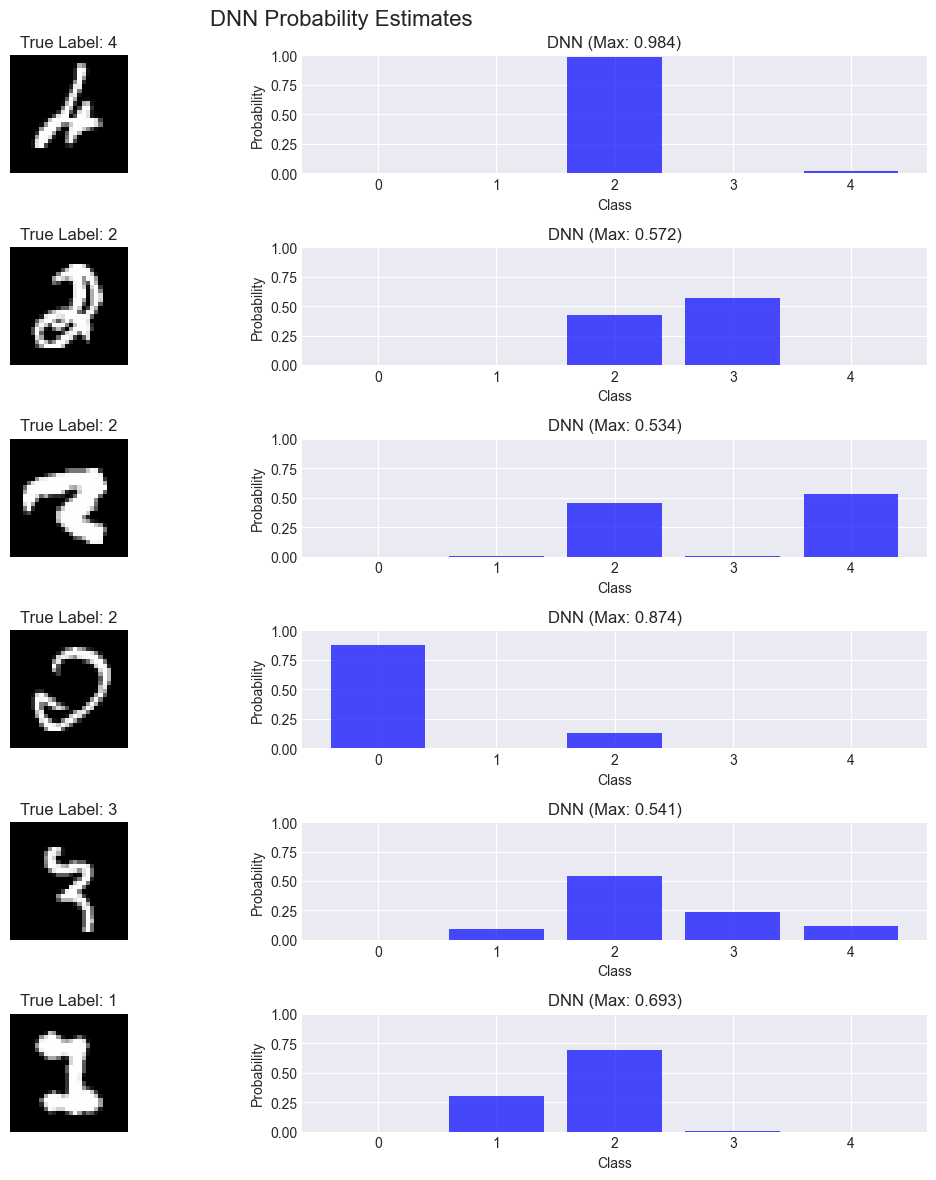

In [8]:
def plot_probabilities_dnn_wrong(dnn_model, x_samples, y_samples):
    """
    Examine probability estimates for DNN on specific examples.
    
    Args:
        dnn_model: Standard DNN model
        x_samples: Sample images
        y_samples: True labels

    """    
    wrong_examples = []
    wrong_true_labels = []
    wrong_model_probs = []
    num_samples = 100

    for i in range(len(y_samples)//num_samples):
        x_sample = x_samples[i * num_samples:(i + 1) * num_samples]
        y_true = y_samples[i * num_samples:(i + 1) * num_samples]
        
        # Get DNN predictions
        dnn_probs = dnn_model.predict(x_sample, verbose=0)
        dnn_preds = [np.argmax(prob) for prob in dnn_probs]

        for j in range(len(y_true)):
            if y_true[j] != dnn_preds[j]:
                wrong_examples.append(x_sample[j])
                wrong_true_labels.append(y_true[j])
                wrong_model_probs.append(dnn_probs[j])

    
    # Plot image
    n_examples = min(6, len(wrong_examples))
    fig, axes = plt.subplots(n_examples, 2, figsize=(12, 2*n_examples))
    fig.suptitle('DNN Probability Estimates', fontsize=16)

    for k in range(n_examples):
        axes[k, 0].imshow(wrong_examples[k].reshape(28, 28), cmap='gray')
        axes[k, 0].set_title(f'True Label: {wrong_true_labels[k]}')
        axes[k, 0].axis('off')
        
        # Plot DNN probabilities
        axes[k, 1].bar(range(5), wrong_model_probs[k], color='blue', alpha=0.7)
        axes[k, 1].set_ylim([0, 1])
        axes[k, 1].set_xlabel('Class')
        axes[k, 1].set_ylabel('Probability')
        axes[k, 1].set_title(f'DNN (Max: {np.max(wrong_model_probs[k]):.3f})')
        axes[k, 1].set_xticks(range(5))
            
    plt.tight_layout()
    plt.show()

# Compare on clean in-distribution examples
print("Probability Estimates for cases the model gets wrong for Clean In-Distribution Data:")
plot_probabilities_dnn_wrong(dnn_model, x_test_0to4, y_test_0to4)

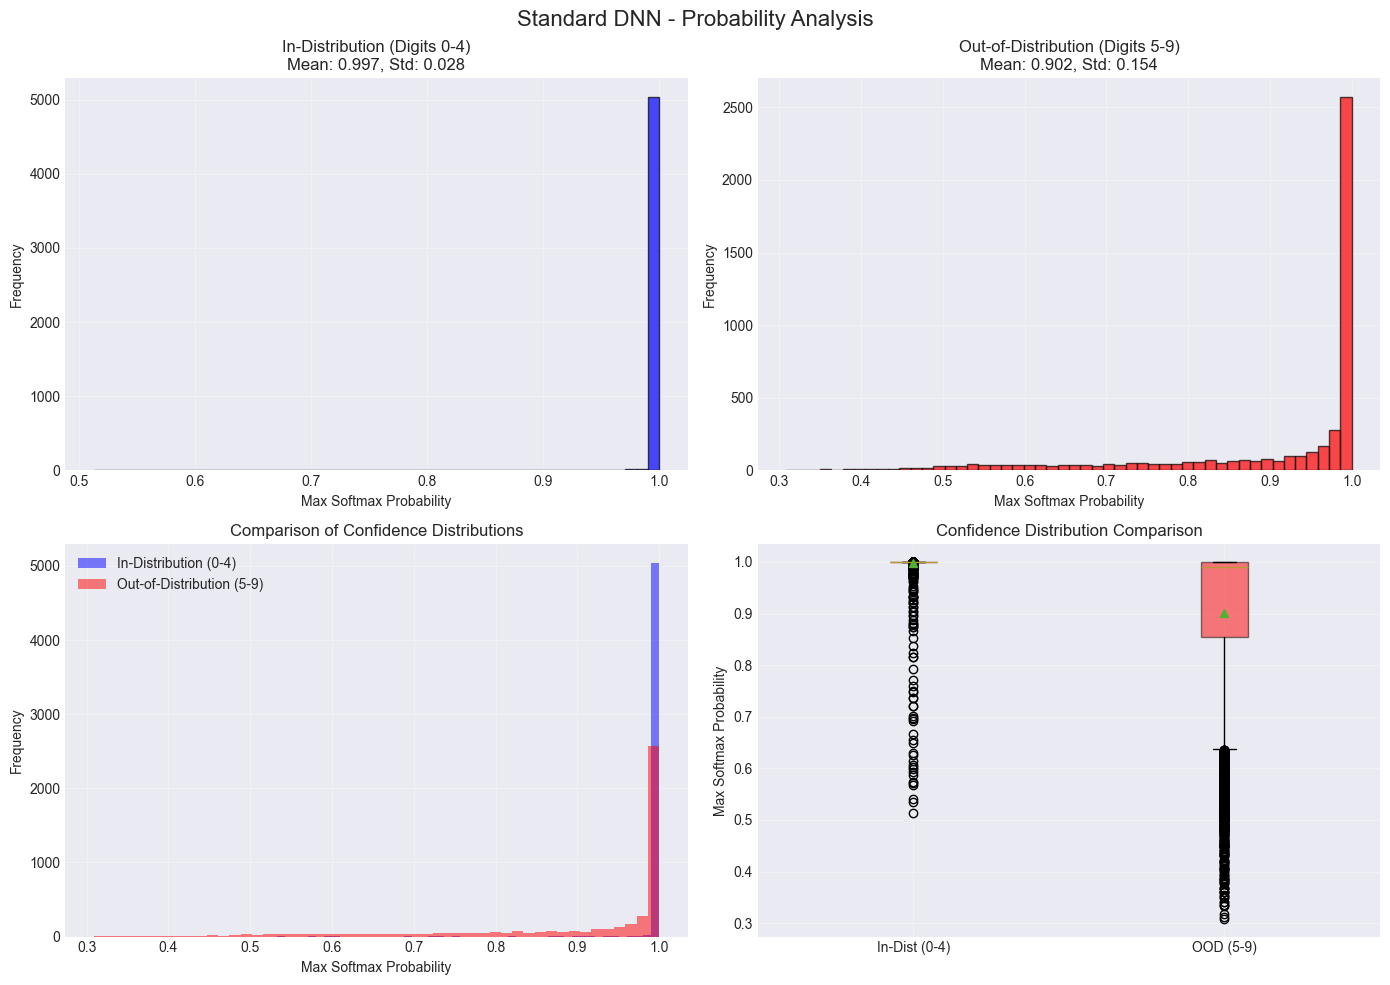


Standard DNN Statistics:
In-Distribution Accuracy: 0.9957
In-Distribution - Mean Max Prob: 0.9971, Std: 0.0282
Out-of-Distribution - Mean Max Prob: 0.9019, Std: 0.1538
Confidence Gap (In-Dist - OOD): 0.0952


In [9]:
def test_and_plot_probabilities(model, x_test_in: np.ndarray, x_test_ood: np.ndarray,
                               y_test_in: np.ndarray, y_test_ood: np.ndarray,
                               model_name: str = "Model",
                               n_samples: int = 1) -> dict:
    """
    Test model on in-distribution and out-of-distribution data,
    and plot histograms of max softmax probabilities.
    
    Args:
        model: Trained model
        x_test_in: In-distribution test data (digits 0-4)
        x_test_ood: Out-of-distribution test data (digits 5-9)
        y_test_in: In-distribution labels
        y_test_ood: OOD labels
        model_name: Name for plot titles
        n_samples: Number of forward passes (1 for standard DNN, >1 for Bayesian)
    
    Returns:
        Dictionary with probability statistics
    """
    # Get predictions for in-distribution data
    if n_samples > 1:
        # For Bayesian models, average over multiple forward passes
        preds_in = np.stack([model(x_test_in, training=False) for _ in range(n_samples)])
        probs_in = np.mean(preds_in, axis=0)
    else:
        probs_in = model.predict(x_test_in, verbose=0)
    
    # Get predictions for OOD data
    if n_samples > 1:
        preds_ood = np.stack([model(x_test_ood, training=False) for _ in range(n_samples)])
        probs_ood = np.mean(preds_ood, axis=0)
    else:
        probs_ood = model.predict(x_test_ood, verbose=0)
    
    # Get maximum probabilities (confidence)
    max_probs_in = np.max(probs_in, axis=1)
    max_probs_ood = np.max(probs_ood, axis=1)
    
    # Calculate accuracy for in-distribution
    preds_in_class = np.argmax(probs_in, axis=1)
    accuracy_in = np.mean(preds_in_class == y_test_in)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{model_name} - Probability Analysis', fontsize=16)
    
    # Plot 1: Histogram of max probabilities for in-distribution
    axes[0, 0].hist(max_probs_in, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_xlabel('Max Softmax Probability')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'In-Distribution (Digits 0-4)\nMean: {np.mean(max_probs_in):.3f}, Std: {np.std(max_probs_in):.3f}')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Histogram of max probabilities for OOD
    axes[0, 1].hist(max_probs_ood, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0, 1].set_xlabel('Max Softmax Probability')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Out-of-Distribution (Digits 5-9)\nMean: {np.mean(max_probs_ood):.3f}, Std: {np.std(max_probs_ood):.3f}')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Overlapping histograms
    axes[1, 0].hist(max_probs_in, bins=50, alpha=0.5, label='In-Distribution (0-4)', color='blue')
    axes[1, 0].hist(max_probs_ood, bins=50, alpha=0.5, label='Out-of-Distribution (5-9)', color='red')
    axes[1, 0].set_xlabel('Max Softmax Probability')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Comparison of Confidence Distributions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Box plot comparison
    box_data = [max_probs_in, max_probs_ood]
    bp = axes[1, 1].boxplot(box_data, labels=['In-Dist (0-4)', 'OOD (5-9)'], 
                            patch_artist=True, showmeans=True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('red')
    for box in bp['boxes']:
        box.set_alpha(0.5)
    axes[1, 1].set_ylabel('Max Softmax Probability')
    axes[1, 1].set_title('Confidence Distribution Comparison')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{model_name} Statistics:")
    print(f"In-Distribution Accuracy: {accuracy_in:.4f}")
    print(f"In-Distribution - Mean Max Prob: {np.mean(max_probs_in):.4f}, Std: {np.std(max_probs_in):.4f}")
    print(f"Out-of-Distribution - Mean Max Prob: {np.mean(max_probs_ood):.4f}, Std: {np.std(max_probs_ood):.4f}")
    print(f"Confidence Gap (In-Dist - OOD): {np.mean(max_probs_in) - np.mean(max_probs_ood):.4f}")
    
    return {
        'max_probs_in': max_probs_in,
        'max_probs_ood': max_probs_ood,
        'accuracy_in': accuracy_in
    }

# Test the standard DNN
dnn_results = test_and_plot_probabilities(
    dnn_model, 
    x_test_0to4, x_test_5to9,
    y_test_0to4, y_test_5to9,
    model_name="Standard DNN"
)

## 5. Create and Test on Noisy MNIST

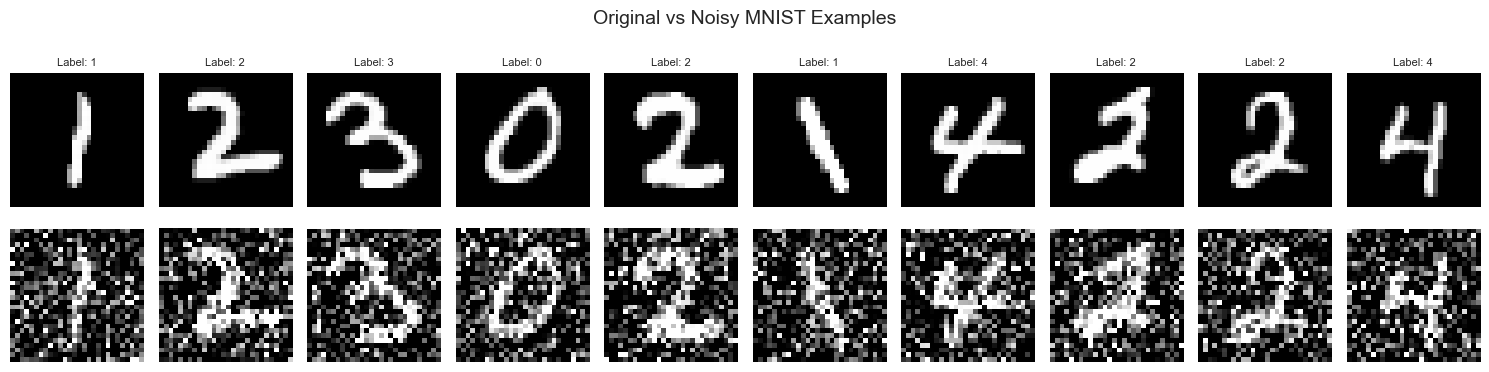


Testing Standard DNN on Noisy Data:


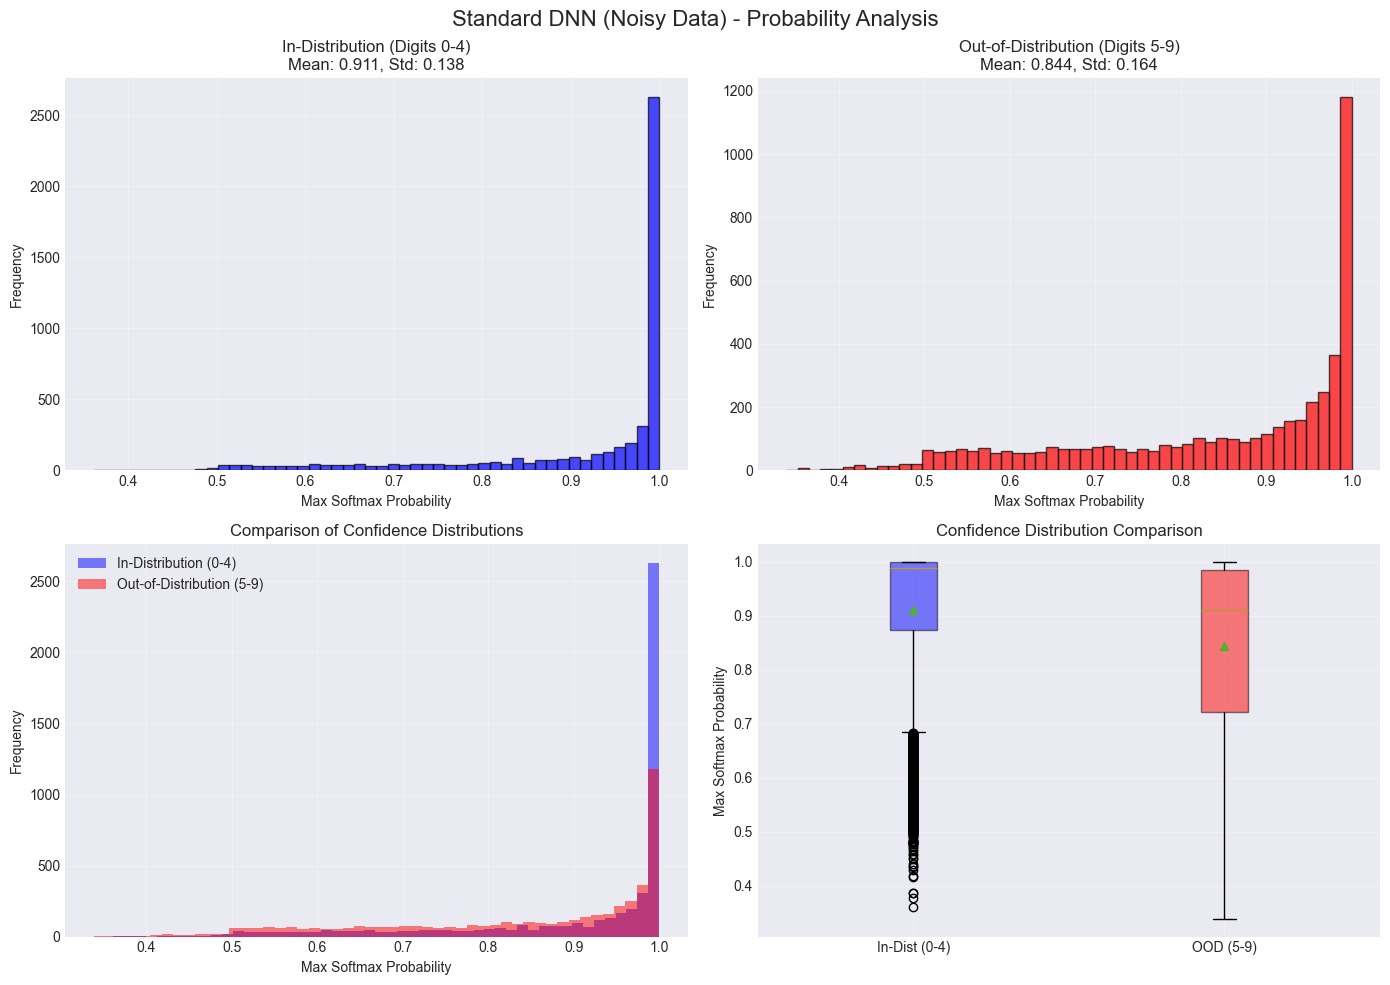


Standard DNN (Noisy Data) Statistics:
In-Distribution Accuracy: 0.6104
In-Distribution - Mean Max Prob: 0.9112, Std: 0.1378
Out-of-Distribution - Mean Max Prob: 0.8439, Std: 0.1635
Confidence Gap (In-Dist - OOD): 0.0674


In [10]:
def create_noisy_mnist(x_data: np.ndarray, noise_factor: float = 0.5) -> np.ndarray:
    """
    Create noisy version of MNIST data.
    
    Args:
        x_data: Original image data
        noise_factor: Amount of noise to add (0-1)
    
    Returns:
        Noisy image data
    """
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=x_data.shape)
    x_noisy = x_data + noise
    # Clip to valid range [0, 1]
    x_noisy = np.clip(x_noisy, 0.0, 1.0)
    return x_noisy

def visualize_noisy_mnist(x_original: np.ndarray, x_noisy: np.ndarray, 
                         y_data: np.ndarray, num_examples: int = 10):
    """
    Visualize original vs noisy MNIST examples side by side.
    
    Args:
        x_original: Original images
        x_noisy: Noisy images
        y_data: Labels
        num_examples: Number of examples to show
    """
    # Reshape if needed
    if len(x_original.shape) == 2:
        x_original = x_original.reshape(-1, 28, 28)
    if len(x_noisy.shape) == 2:
        x_noisy = x_noisy.reshape(-1, 28, 28)
    
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 4))
    fig.suptitle('Original vs Noisy MNIST Examples', fontsize=14)
    
    indices = np.random.choice(len(x_original), num_examples, replace=False)
    
    for i in range(num_examples):
        idx = indices[i]
        
        # Original images
        axes[0, i].imshow(x_original[idx], cmap='gray')
        axes[0, i].set_title(f'Label: {y_data[idx]}', fontsize=8)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', fontsize=10)
        
        # Noisy images
        axes[1, i].imshow(x_noisy[idx], cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Noisy', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create noisy versions of test sets
x_test_0to4_noisy = create_noisy_mnist(x_test_0to4, noise_factor=0.5)
x_test_5to9_noisy = create_noisy_mnist(x_test_5to9, noise_factor=0.5)

# Visualize noisy examples
visualize_noisy_mnist(x_test_0to4, x_test_0to4_noisy, y_test_0to4, num_examples=10)

# Test DNN on noisy data
print("\nTesting Standard DNN on Noisy Data:")
dnn_noisy_results = test_and_plot_probabilities(
    dnn_model,
    x_test_0to4_noisy, x_test_5to9_noisy,
    y_test_0to4, y_test_5to9,
    model_name="Standard DNN (Noisy Data)"
)

## 6. Train Bayesian Neural Network Classifier

Training Bayesian Neural Network on digits 0-4...
Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 9.0261 - val_accuracy: 0.9765 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 8.3372 - val_accuracy: 0.9844 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9777 - loss: 7.7724 - val_accuracy: 0.9899 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 7.2201 - val_accuracy: 0.9899 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9843 - loss: 6.6751 - val_accuracy: 0.9914 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 6.1482 - val_accuracy: 0.9920 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 7/100
240/240 ━━━━━━━━━━━━

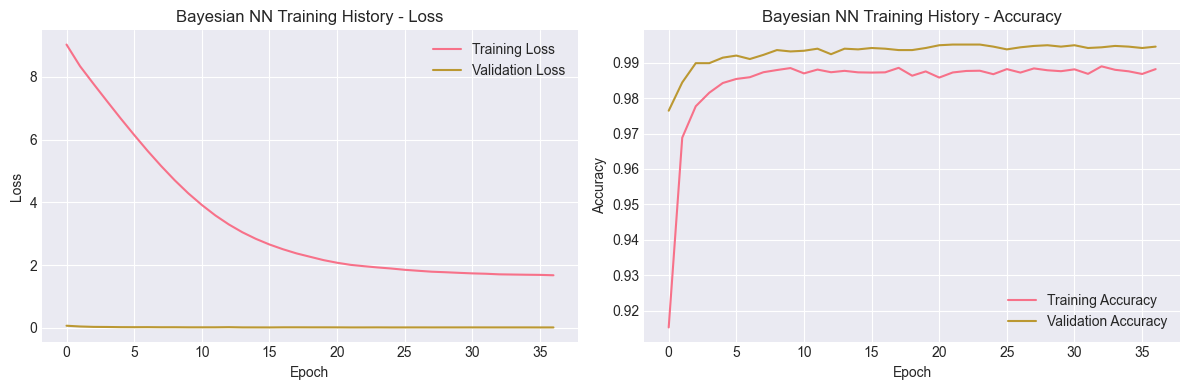


Test accuracy on digits 0-4: 0.9951
Model architecture saved to: outputs/bayesian_model.png


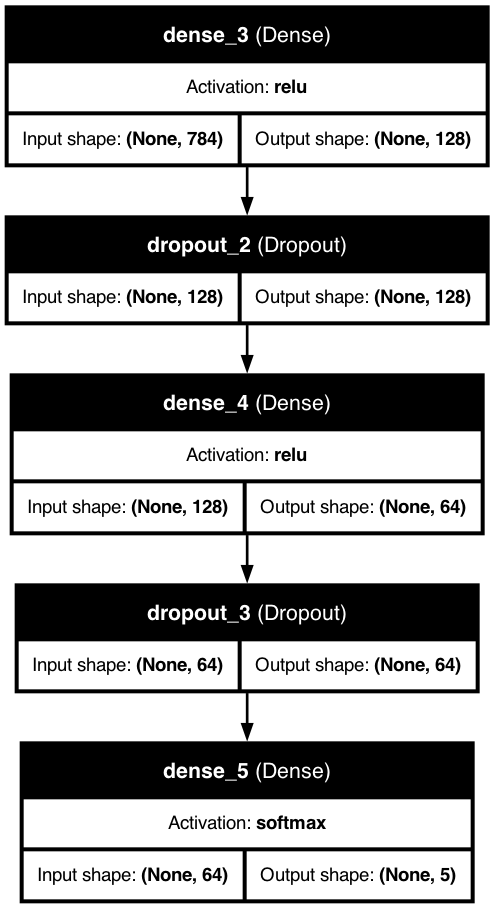

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

def create_bayesian_nn(input_dim: int = 784,
                       num_classes: int = 5,
                       hidden_units: list = [128, 64],
                       num_train_samples: int = None) -> tf.keras.Model:
    """
    Create a Bayesian Neural Network using TensorFlow Probability.
    
    Args:
        input_dim: Input dimension
        num_classes: Number of output classes
        hidden_units: List of hidden layer sizes
        num_train_samples: Number of training samples (for KL divergence scaling)
    
    Returns:
        Compiled Bayesian NN model
    """
    # Define KL divergence weight
    kl_divergence_weight = 1.0 / num_train_samples if num_train_samples else 1e-4
    
    # Custom Bayesian Dense Layer using Flipout estimator
    class BayesianDense(tf.keras.layers.Layer):
        def __init__(self, units, kl_weight, **kwargs):
            super().__init__(**kwargs)
            self.units = units
            self.kl_weight = kl_weight
            
        def build(self, input_shape):
            input_dim = input_shape[-1]
            
            # Weight parameters (mean and log std)
            self.kernel_mean = self.add_weight(
                name='kernel_mean',
                shape=(input_dim, self.units),
                initializer='glorot_uniform',
                trainable=True
            )
            self.kernel_log_std = self.add_weight(
                name='kernel_log_std',
                shape=(input_dim, self.units),
                initializer=tf.keras.initializers.Constant(-3.0),
                trainable=True
            )
            
            # Bias parameters
            self.bias_mean = self.add_weight(
                name='bias_mean',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )
            self.bias_log_std = self.add_weight(
                name='bias_log_std',
                shape=(self.units,),
                initializer=tf.keras.initializers.Constant(-3.0),
                trainable=True
            )
            
        def call(self, inputs, training=None):
            if training:
                # Sample weights during training
                kernel_std = tf.nn.softplus(self.kernel_log_std) + 1e-6
                kernel = self.kernel_mean + kernel_std * tf.random.normal(tf.shape(self.kernel_mean))
                
                bias_std = tf.nn.softplus(self.bias_log_std) + 1e-6
                bias = self.bias_mean + bias_std * tf.random.normal(tf.shape(self.bias_mean))
                
                # KL divergence
                kernel_kl = tf.reduce_sum(
                    -tf.math.log(kernel_std) + 0.5 * (tf.square(kernel_std) + tf.square(self.kernel_mean)) - 0.5
                )
                bias_kl = tf.reduce_sum(
                    -tf.math.log(bias_std) + 0.5 * (tf.square(bias_std) + tf.square(self.bias_mean)) - 0.5
                )
                
                self.add_loss(self.kl_weight * (kernel_kl + bias_kl))
            else:
                # Use mean weights during inference
                kernel = self.kernel_mean
                bias = self.bias_mean
            
            return tf.matmul(inputs, kernel) + bias
    
    # Build model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        
        # First Bayesian layer
        BayesianDense(hidden_units[0], kl_divergence_weight),
        tf.keras.layers.Activation('relu'),
        
        # Second Bayesian layer
        BayesianDense(hidden_units[1], kl_divergence_weight),
        tf.keras.layers.Activation('relu'),
        
        # Output layer
        BayesianDense(num_classes, kl_divergence_weight),
        tf.keras.layers.Softmax()
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

def train_bayesian_classifier(x_train: np.ndarray, y_train: np.ndarray,
                             x_val: np.ndarray, y_val: np.ndarray,
                             epochs: int = 100,
                             batch_size: int = 128,
                             verbose: int = 1) -> tf.keras.Model:
    """
    Train a Bayesian Neural Network classifier.
    
    Args:
        x_train, y_train: Training data
        x_val, y_val: Validation data
        epochs: Number of training epochs
        batch_size: Batch size
        verbose: Verbosity level
    
    Returns:
        Trained Bayesian NN model
    """
    # Create model
    model = create_bayesian_nn(
        input_dim=x_train.shape[1],
        num_classes=5,
        num_train_samples=x_train.shape[0]
    )
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    # Reduce learning rate callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    # Train model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=verbose
    )
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Bayesian NN Training History - Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Bayesian NN Training History - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train the Bayesian NN
print("Training Bayesian Neural Network on digits 0-4...")
bnn_model = train_bayesian_classifier(
    x_train_0to4, y_train_0to4,
    x_test_0to4, y_test_0to4,
    epochs=100,
    batch_size=128
)

# Evaluate on test set
test_loss, test_acc = bnn_model.evaluate(x_test_0to4, y_test_0to4, verbose=0)
print(f"\nTest accuracy on digits 0-4: {test_acc:.4f}")

# Visualizing the model architecture
visualize_model_architecture(dnn_model, filename='outputs/bayesian_model.png', rankdir='TB')

## 7. Test Bayesian NN with Uncertainty Quantification

Testing Bayesian NN on Clean Data:


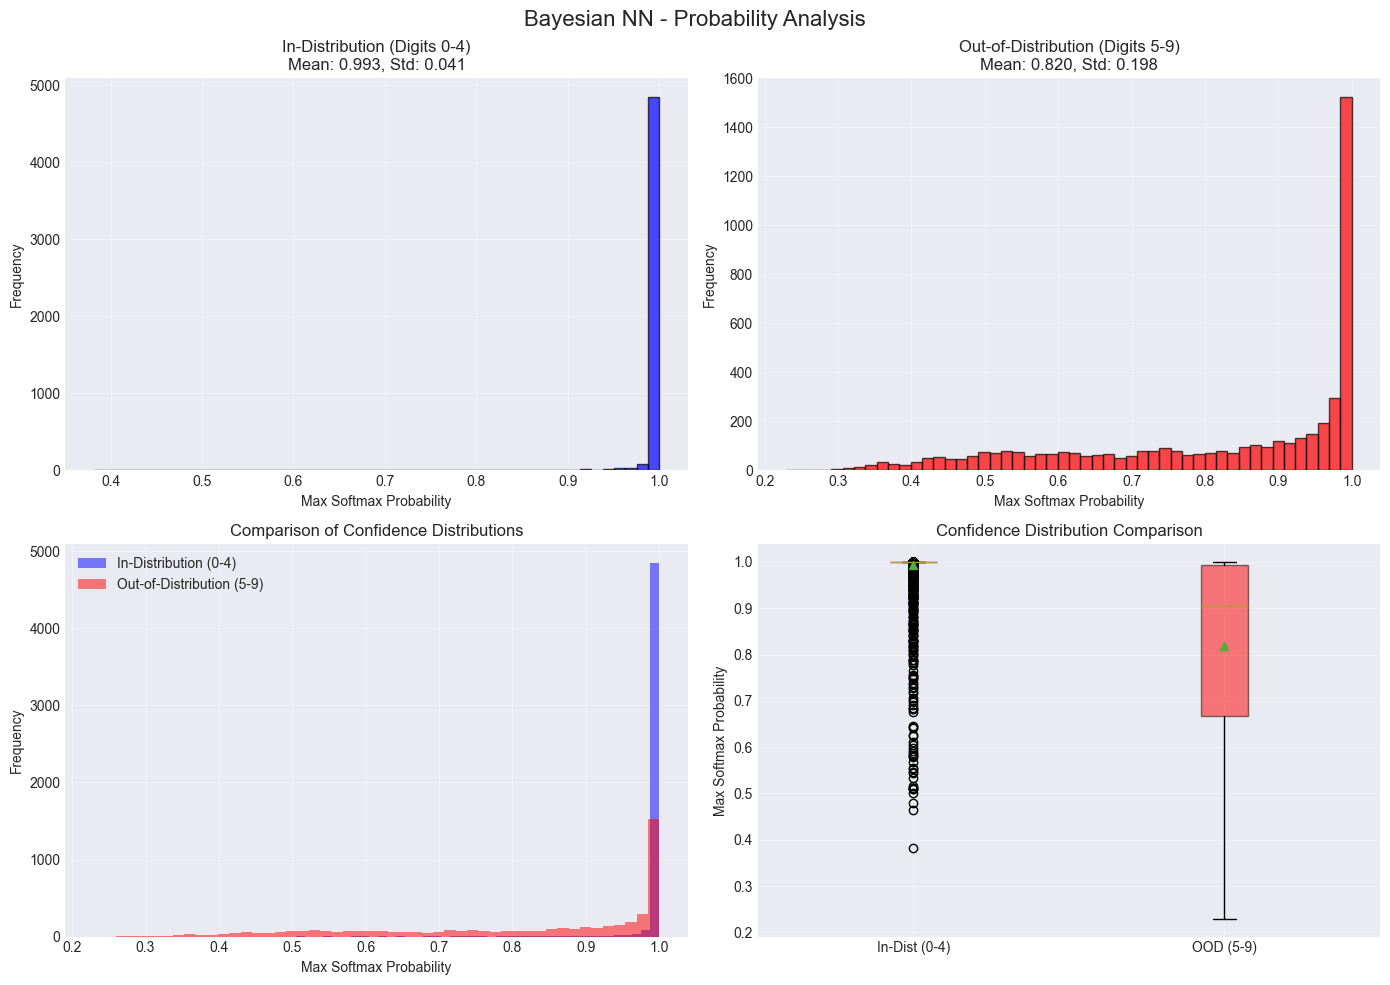


Bayesian NN Statistics:
In-Distribution Accuracy: 0.9928
In-Distribution - Mean Max Prob: 0.9931, Std: 0.0409
Out-of-Distribution - Mean Max Prob: 0.8195, Std: 0.1976
Confidence Gap (In-Dist - OOD): 0.1736

Testing Bayesian NN on Noisy Data:


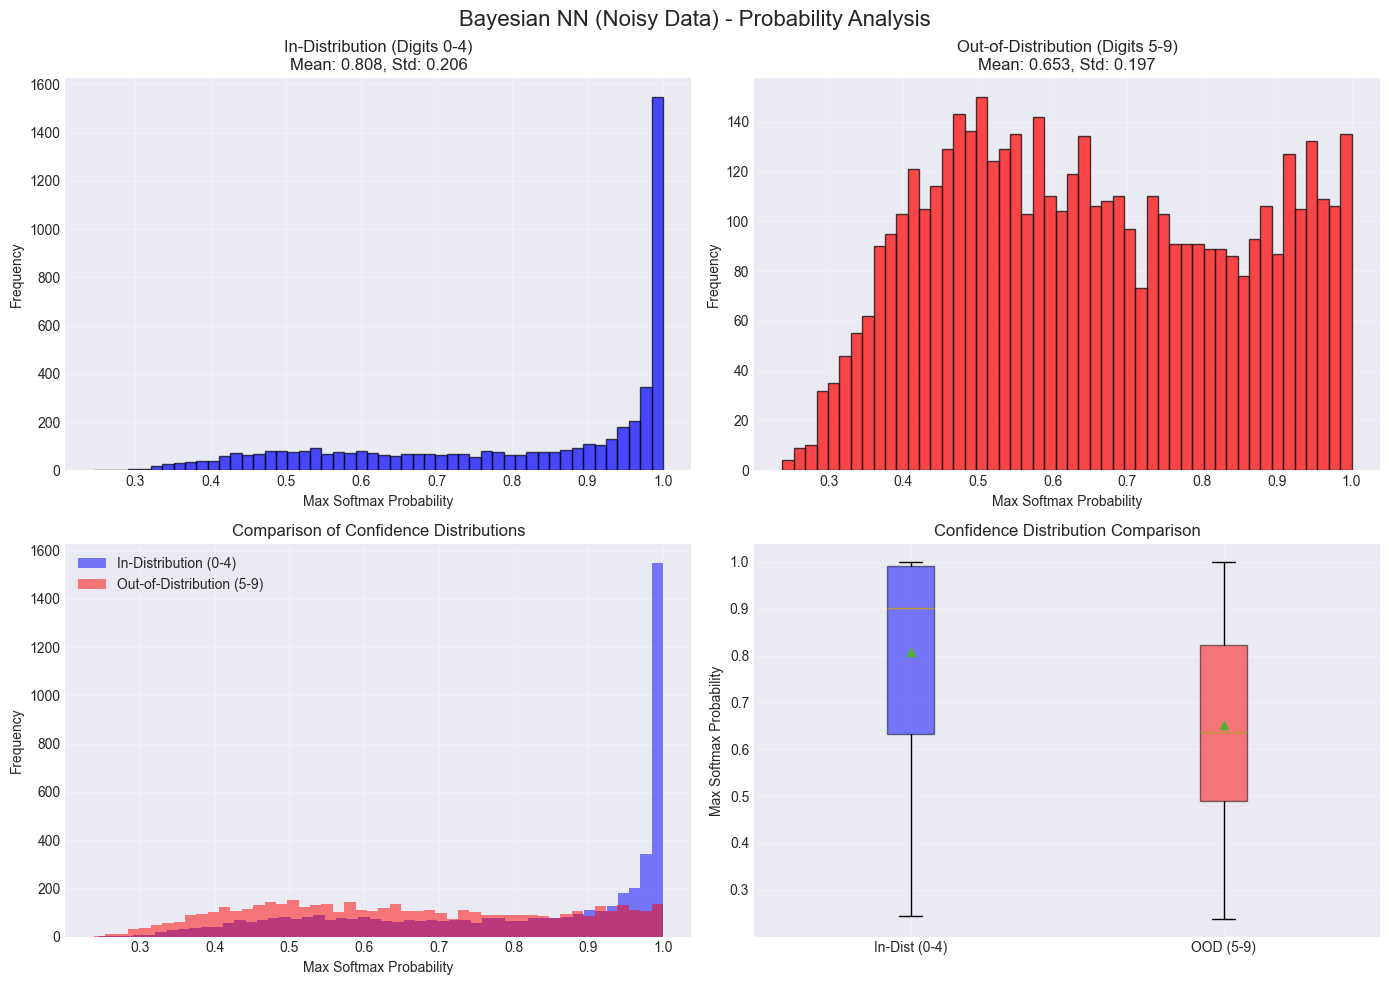


Bayesian NN (Noisy Data) Statistics:
In-Distribution Accuracy: 0.6960
In-Distribution - Mean Max Prob: 0.8080, Std: 0.2061
Out-of-Distribution - Mean Max Prob: 0.6528, Std: 0.1970
Confidence Gap (In-Dist - OOD): 0.1552


In [9]:
def get_bayesian_predictions(model, x_data: np.ndarray, n_samples: int = 100):
    """
    Get predictions from Bayesian NN with uncertainty estimates.
    
    Args:
        model: Bayesian NN model
        x_data: Input data
        n_samples: Number of stochastic forward passes
    
    Returns:
        Mean predictions and uncertainty estimates
    """
    predictions = []
    
    for _ in range(n_samples):
        preds = model(x_data, training=False)
        predictions.append(preds)
    
    predictions = np.array(predictions)
    
    # Calculate mean and standard deviation
    mean_preds = np.mean(predictions, axis=0)
    std_preds = np.std(predictions, axis=0)
    
    return mean_preds, std_preds, predictions

# Test Bayesian NN on clean data
print("Testing Bayesian NN on Clean Data:")
bnn_results = test_and_plot_probabilities(
    bnn_model,
    x_test_0to4, x_test_5to9,
    y_test_0to4, y_test_5to9,
    model_name="Bayesian NN",
    n_samples=50
)

# Test Bayesian NN on noisy data
print("\nTesting Bayesian NN on Noisy Data:")
bnn_noisy_results = test_and_plot_probabilities(
    bnn_model,
    x_test_0to4_noisy, x_test_5to9_noisy,
    y_test_0to4, y_test_5to9,
    model_name="Bayesian NN (Noisy Data)",
    n_samples=50
)

## 8. Comparative Analysis with Uncertainty Visualization

Uncertainty Comparison on Clean In-Distribution Data:


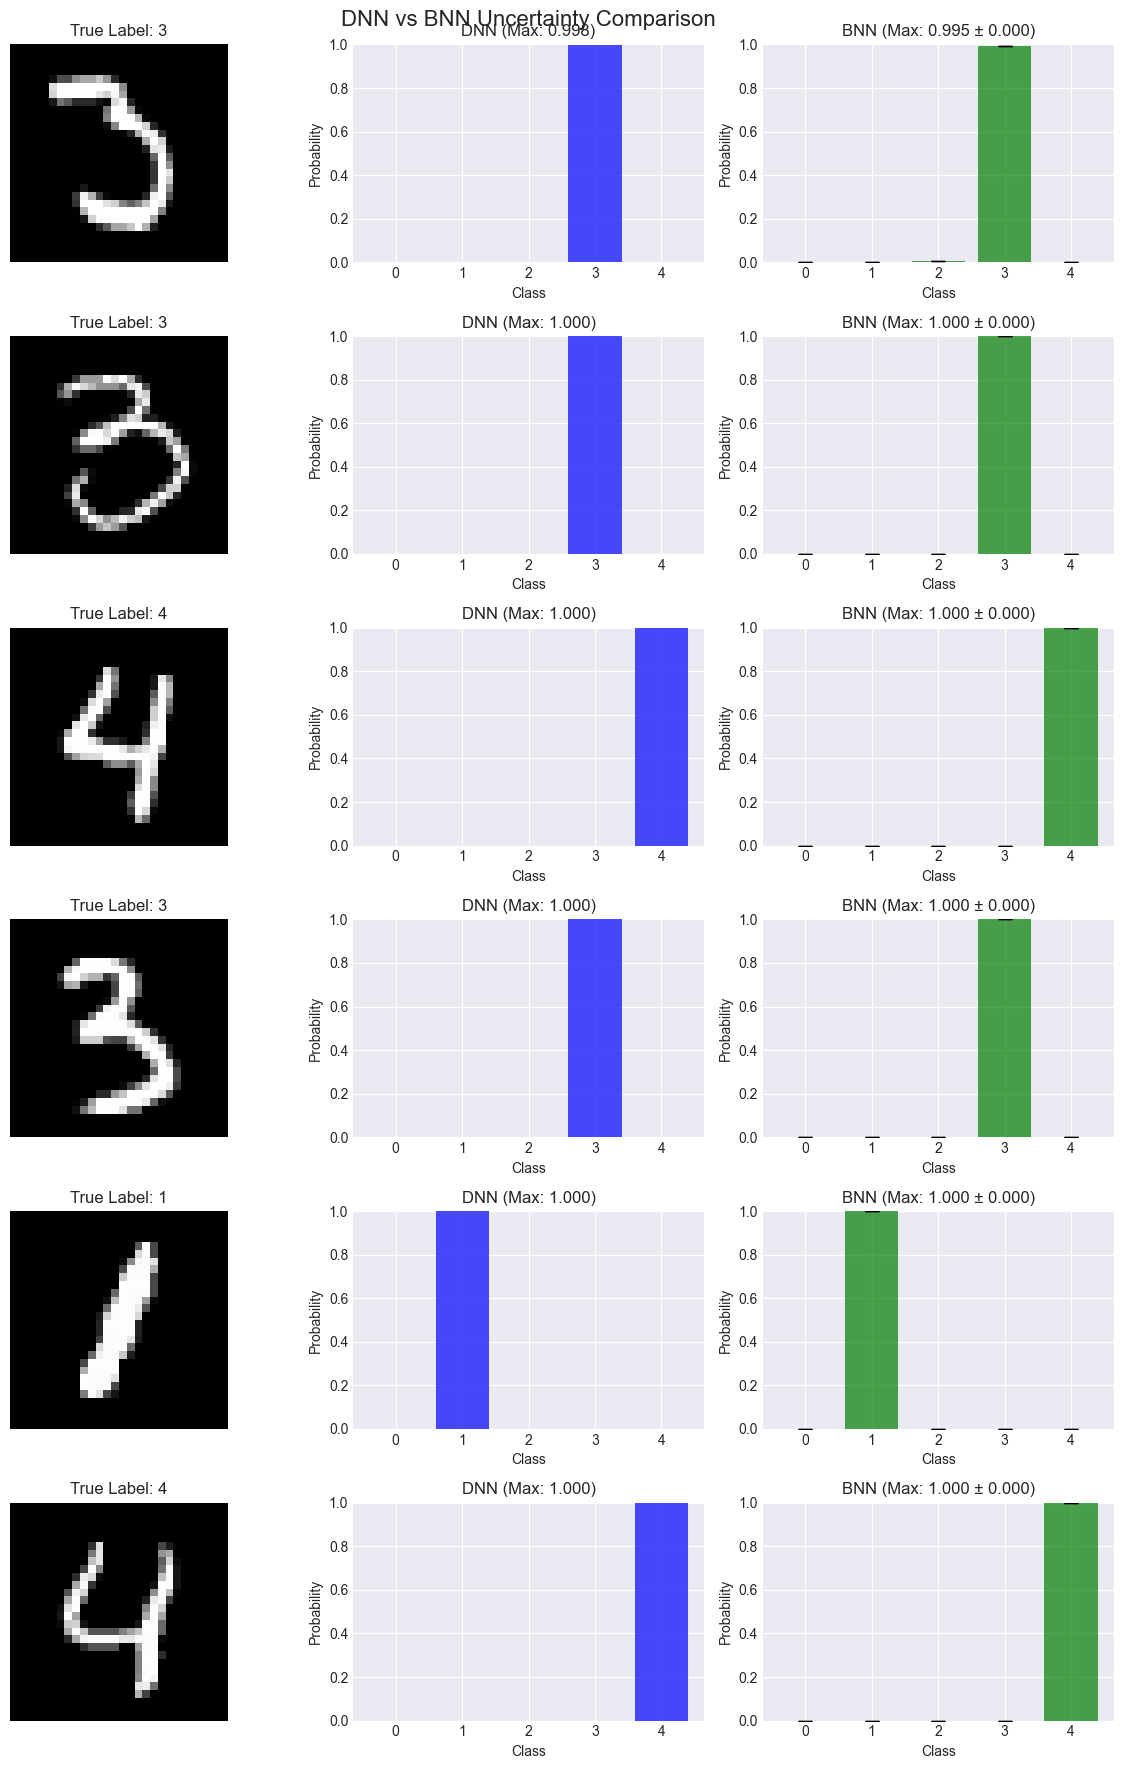


Uncertainty Comparison on Noisy Data:


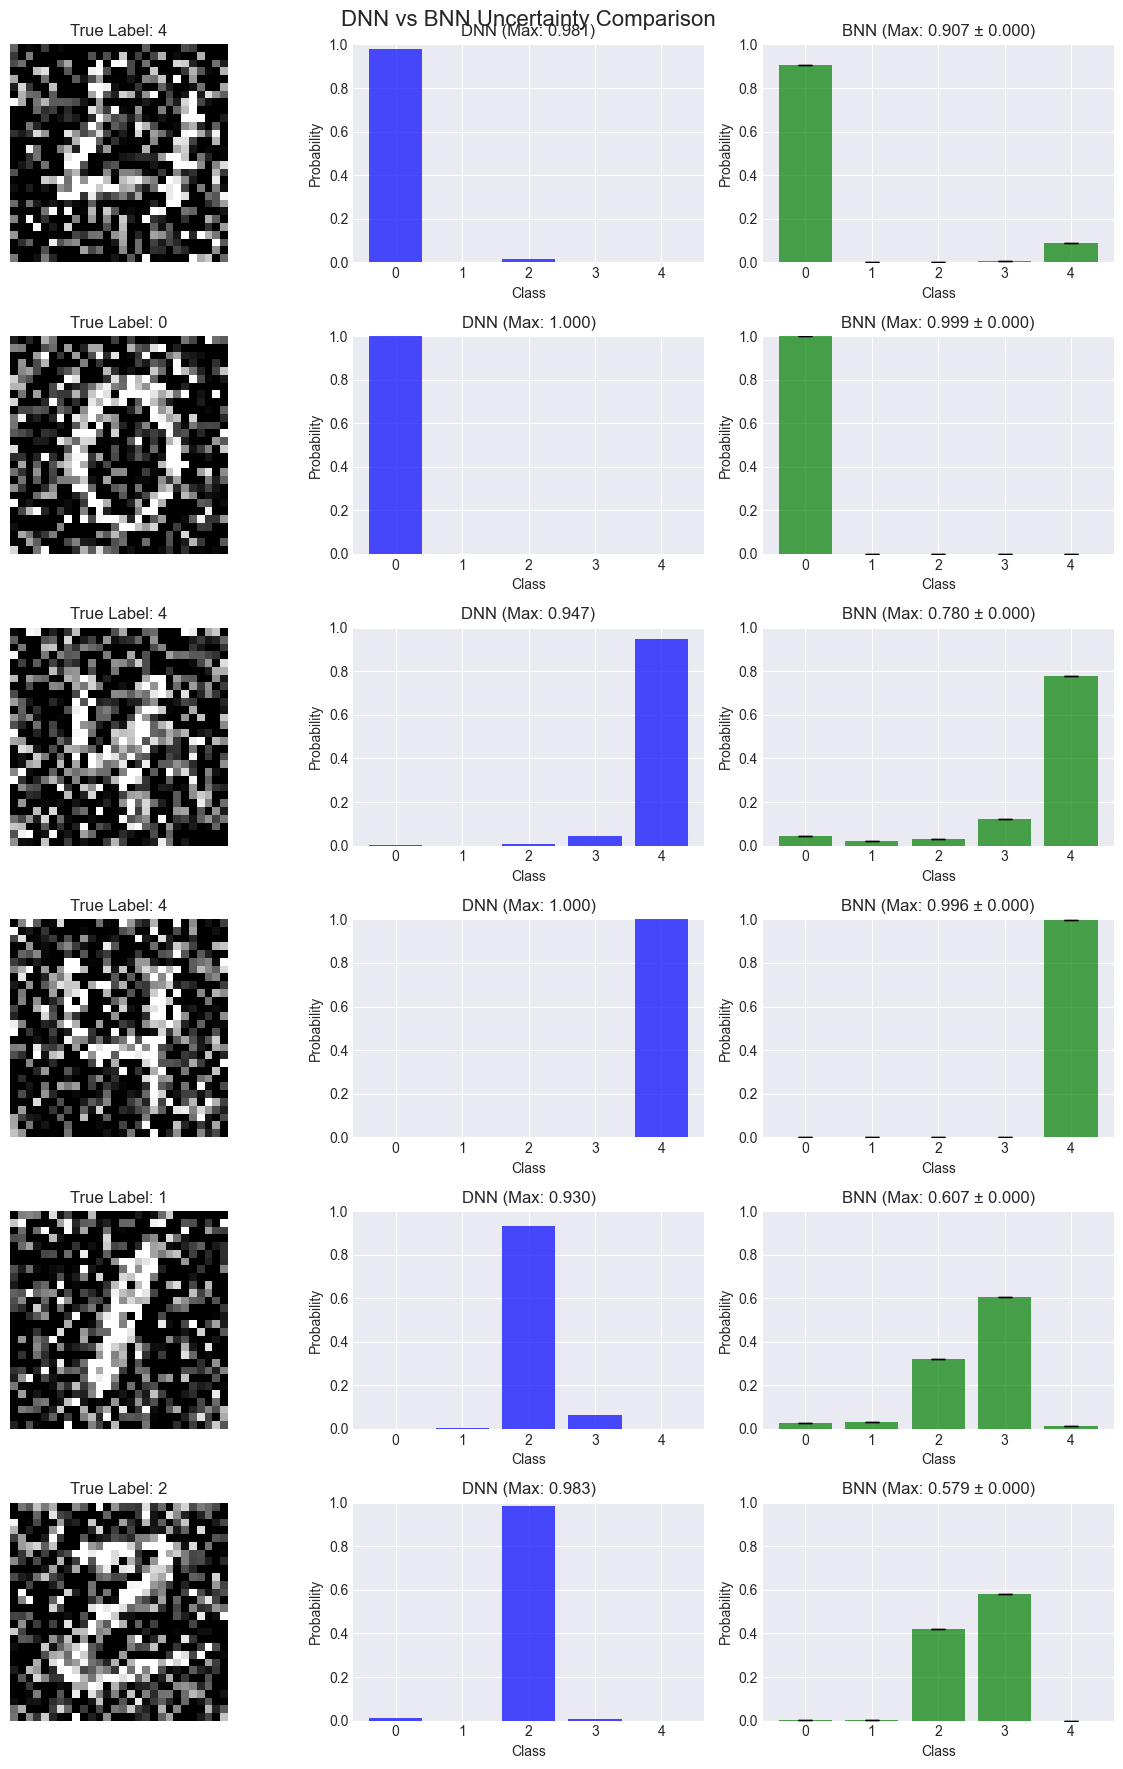


Uncertainty Comparison on Out-of-Distribution Data:


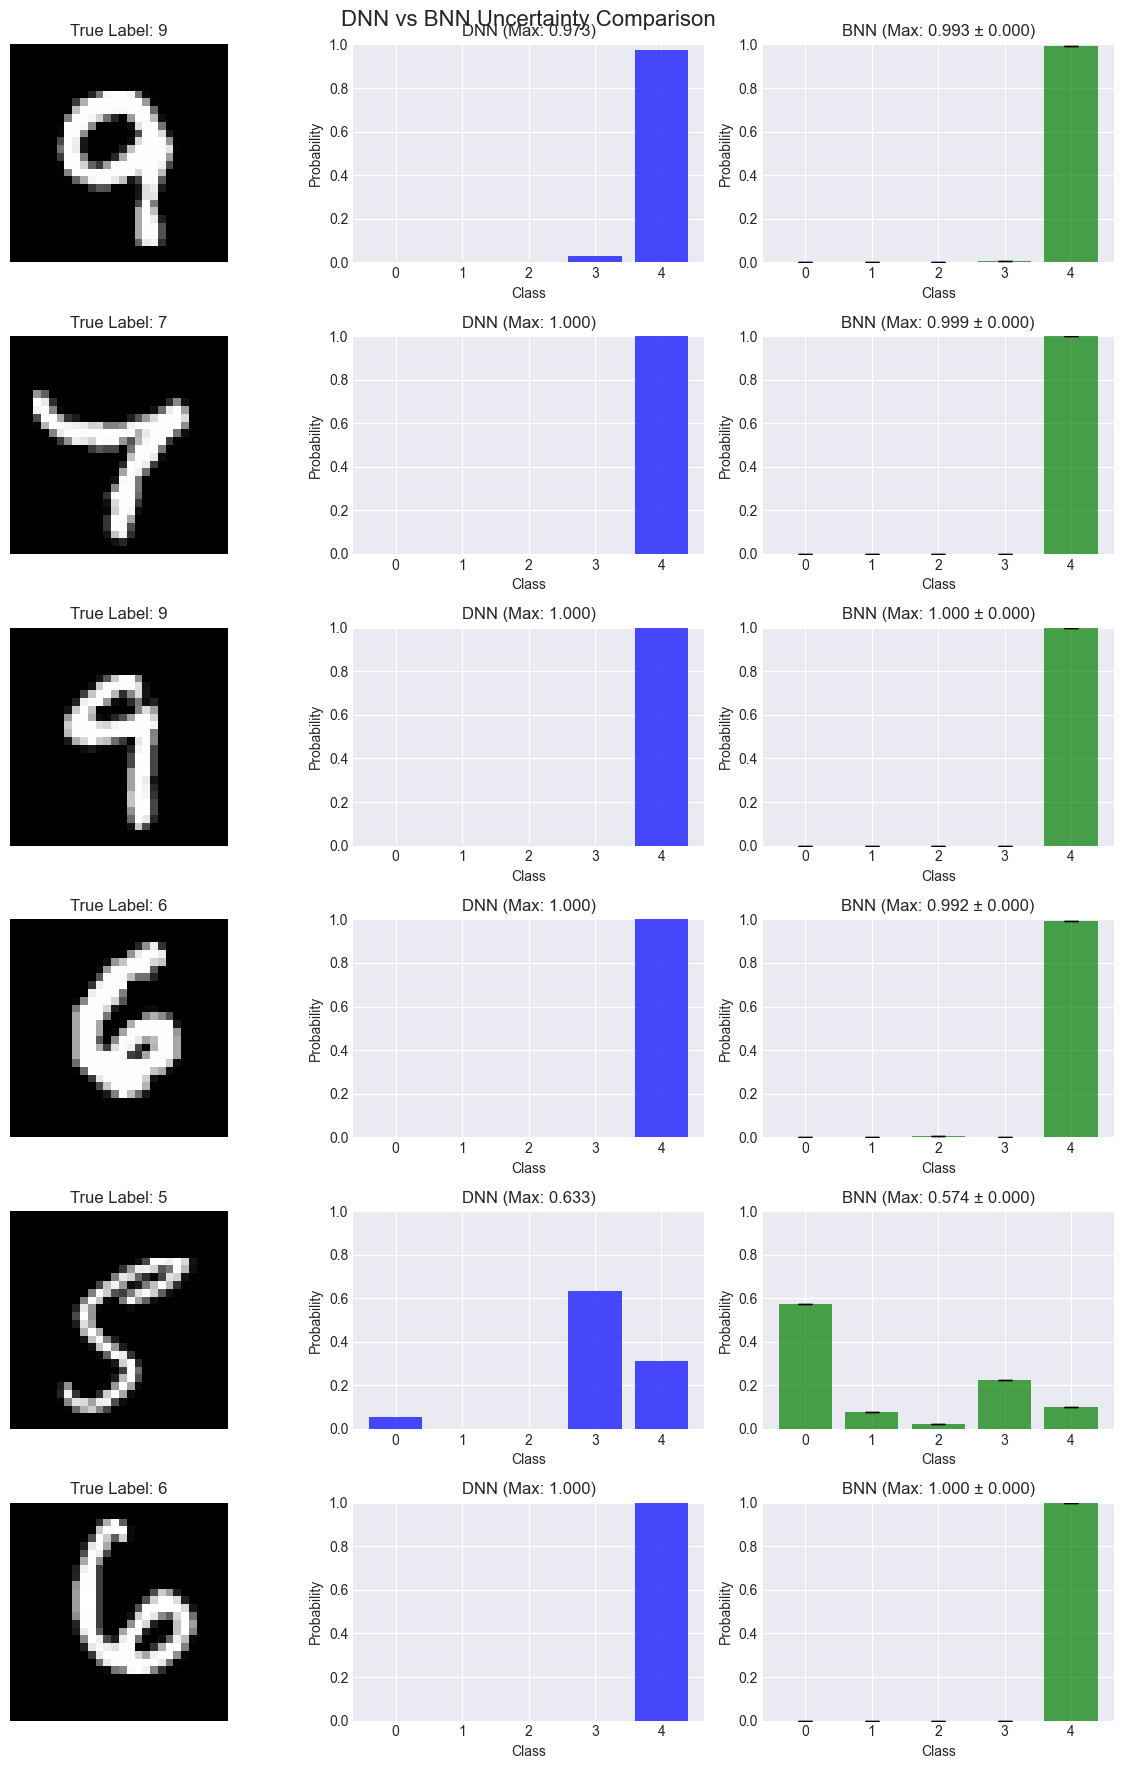

In [10]:
def plot_uncertainty_comparison(dnn_model, bnn_model, x_samples, y_samples, n_bnn_samples=50):
    """
    Compare uncertainty estimates between DNN and BNN on specific examples.
    
    Args:
        dnn_model: Standard DNN model
        bnn_model: Bayesian NN model
        x_samples: Sample images
        y_samples: True labels
        n_bnn_samples: Number of forward passes for BNN
    """
    n_examples = min(6, len(x_samples))
    indices = np.random.choice(len(x_samples), n_examples, replace=False)
    
    fig, axes = plt.subplots(n_examples, 3, figsize=(12, 3*n_examples))
    fig.suptitle('DNN vs BNN Uncertainty Comparison', fontsize=16)
    
    for i, idx in enumerate(indices):
        x_sample = x_samples[idx:idx+1]
        y_true = y_samples[idx]
        
        # Get DNN predictions
        dnn_probs = dnn_model.predict(x_sample, verbose=0)[0]
        
        # Get BNN predictions with uncertainty
        bnn_mean, bnn_std, bnn_samples = get_bayesian_predictions(bnn_model, x_sample, n_bnn_samples)
        bnn_mean = bnn_mean[0]
        bnn_std = bnn_std[0]
        
        # Plot image
        axes[i, 0].imshow(x_sample.reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f'True Label: {y_true}')
        axes[i, 0].axis('off')
        
        # Plot DNN probabilities
        axes[i, 1].bar(range(5), dnn_probs, color='blue', alpha=0.7)
        axes[i, 1].set_ylim([0, 1])
        axes[i, 1].set_xlabel('Class')
        axes[i, 1].set_ylabel('Probability')
        axes[i, 1].set_title(f'DNN (Max: {np.max(dnn_probs):.3f})')
        axes[i, 1].set_xticks(range(5))
        
        # Plot BNN probabilities with error bars
        axes[i, 2].bar(range(5), bnn_mean, yerr=bnn_std, color='green', alpha=0.7, capsize=5)
        axes[i, 2].set_ylim([0, 1])
        axes[i, 2].set_xlabel('Class')
        axes[i, 2].set_ylabel('Probability')
        axes[i, 2].set_title(f'BNN (Max: {np.max(bnn_mean):.3f} ± {bnn_std[np.argmax(bnn_mean)]:.3f})')
        axes[i, 2].set_xticks(range(5))
    
    plt.tight_layout()
    plt.show()

# Compare on clean in-distribution examples
print("Uncertainty Comparison on Clean In-Distribution Data:")
plot_uncertainty_comparison(dnn_model, bnn_model, x_test_0to4[:100], y_test_0to4[:100])

# Compare on noisy examples
print("\nUncertainty Comparison on Noisy Data:")
plot_uncertainty_comparison(dnn_model, bnn_model, x_test_0to4_noisy[:100], y_test_0to4[:100])

# Compare on OOD examples
print("\nUncertainty Comparison on Out-of-Distribution Data:")
plot_uncertainty_comparison(dnn_model, bnn_model, x_test_5to9[:100], y_test_5to9[:100])

## 9. Summary Statistics and Key Insights

In [11]:
def create_summary_table(dnn_results, bnn_results, dnn_noisy_results, bnn_noisy_results):
    """
    Create a summary table comparing DNN and BNN performance.
    """
    import pandas as pd
    
    summary_data = {
        'Model': ['Standard DNN', 'Bayesian NN', 'Standard DNN', 'Bayesian NN'],
        'Data Type': ['Clean', 'Clean', 'Noisy', 'Noisy'],
        'In-Dist Accuracy': [
            dnn_results['accuracy_in'],
            bnn_results['accuracy_in'],
            dnn_noisy_results['accuracy_in'],
            bnn_noisy_results['accuracy_in']
        ],
        'In-Dist Confidence': [
            np.mean(dnn_results['max_probs_in']),
            np.mean(bnn_results['max_probs_in']),
            np.mean(dnn_noisy_results['max_probs_in']),
            np.mean(bnn_noisy_results['max_probs_in'])
        ],
        'OOD Confidence': [
            np.mean(dnn_results['max_probs_ood']),
            np.mean(bnn_results['max_probs_ood']),
            np.mean(dnn_noisy_results['max_probs_ood']),
            np.mean(bnn_noisy_results['max_probs_ood'])
        ],
        'Confidence Gap': [
            np.mean(dnn_results['max_probs_in']) - np.mean(dnn_results['max_probs_ood']),
            np.mean(bnn_results['max_probs_in']) - np.mean(bnn_results['max_probs_ood']),
            np.mean(dnn_noisy_results['max_probs_in']) - np.mean(dnn_noisy_results['max_probs_ood']),
            np.mean(bnn_noisy_results['max_probs_in']) - np.mean(bnn_noisy_results['max_probs_ood'])
        ]
    }
    
    df = pd.DataFrame(summary_data)
    df = df.round(4)
    
    print("\n" + "="*80)
    print("PERFORMANCE SUMMARY: DNN vs BNN")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    return df

# Create summary table
summary_df = create_summary_table(dnn_results, bnn_results, dnn_noisy_results, bnn_noisy_results)

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print("""
1. UNCERTAINTY QUANTIFICATION:
   - Bayesian NNs provide natural uncertainty estimates through weight distributions
   - Standard DNNs tend to be overconfident, especially on OOD data
   - BNNs show larger confidence gaps between in-distribution and OOD data

2. ROBUSTNESS TO NOISE:
   - BNNs typically maintain better calibrated confidence on noisy inputs
   - Standard DNNs may show minimal confidence reduction even with heavy noise

3. OUT-OF-DISTRIBUTION DETECTION:
   - BNNs generally assign lower confidence to OOD samples (digits 5-9)
   - This makes BNNs more suitable for detecting when the model is uncertain

4. COMPUTATIONAL TRADE-OFFS:
   - BNNs require multiple forward passes for uncertainty estimation
   - Training time is typically longer due to sampling from weight distributions
   - Inference is slower but provides richer information about predictions

5. PRACTICAL APPLICATIONS:
   - Use BNNs when uncertainty estimates are critical (medical diagnosis, autonomous systems)
   - Use standard DNNs when speed is priority and confidence calibration is less critical
""")
print("="*80)


PERFORMANCE SUMMARY: DNN vs BNN
       Model Data Type  In-Dist Accuracy  In-Dist Confidence  OOD Confidence  Confidence Gap
Standard DNN     Clean            0.9942              0.9977          0.9085          0.0892
 Bayesian NN     Clean            0.9928              0.9931          0.8195          0.1736
Standard DNN     Noisy            0.6468              0.9140          0.8473          0.0667
 Bayesian NN     Noisy            0.6960              0.8080          0.6528          0.1552

KEY INSIGHTS

1. UNCERTAINTY QUANTIFICATION:
   - Bayesian NNs provide natural uncertainty estimates through weight distributions
   - Standard DNNs tend to be overconfident, especially on OOD data
   - BNNs show larger confidence gaps between in-distribution and OOD data

2. ROBUSTNESS TO NOISE:
   - BNNs typically maintain better calibrated confidence on noisy inputs
   - Standard DNNs may show minimal confidence reduction even with heavy noise

3. OUT-OF-DISTRIBUTION DETECTION:
   - BNNs gener